<a target="_blank" href="https://colab.research.google.com/github/ashkan-mokarian/d2l-pytorch/blob/main/chapter_linear_NN_classification/1_linear_classification_with_fashionmnist.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip install d2l==1.0.0a0

In [3]:
import time
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l

In [4]:
d2l.use_svg_display()

# Data

In [34]:
class FashionMNIST(d2l.DataModule):
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28), num_workers=2):
        super().__init__(num_workers=num_workers)
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

In [35]:
data = FashionMNIST(resize=(32, 32))
print(len(data.train), len(data.val))
print(data.train[0][0].shape)

60000 10000
torch.Size([1, 32, 32])


In [36]:
@d2l.add_to_class(FashionMNIST)
def text_labels(self, indices):
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

In [37]:
# for mini-batch data loading
@d2l.add_to_class(FashionMNIST)
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(
        data, self.batch_size, shuffle=train, num_workers=self.num_workers)

ts = time.time()
for X, y in data.train_dataloader():
    pass
print("One pass over train data took:", time.time()-ts, ' seconds')

X.shape, X.dtype, y.shape, y.dtype  # 32 because this is the last batch

One pass over train data took: 13.411950826644897  seconds


(torch.Size([32, 1, 32, 32]), torch.float32, torch.Size([32]), torch.int64)

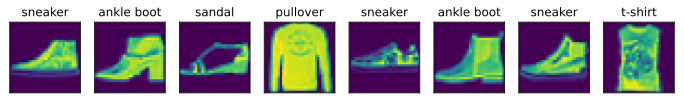

In [38]:
# d2l for visualization
@d2l.add_to_class(FashionMNIST)
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), num_rows=nrows, num_cols=ncols, titles=labels)

batch = next(iter(data.train_dataloader()))
data.visualize(batch)

# Linear Classification as Regression from Scratch

In [39]:
# Just for testing.
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.6, 0.3, 0.1], [0.3, 0.4, 0.3]])

acc = y_hat.argmax(dim=1) == y
acc = acc.sum() / acc.numel()
acc

tensor(0.5000)

In [40]:
# Softmax
def softmax(o):
    o_exp = torch.exp(o)
    return o_exp / o_exp.sum(dim=1, keepdim=True)
o = torch.randn((2,3))
y_hat = softmax(o)
print(y_hat.sum(dim=1))

tensor([1.0000, 1.0000])


## Model

In [44]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs), requires_grad=True)
        self.b = torch.zeros(size=(num_outputs,), requires_grad=True)
    
    def parameters(self):
        return [self.W, self.b]

    def forward(self, X):
        X = X.reshape(-1, self.W.shape[0])
        return softmax(torch.matmul(X, self.W) + self.b )

## Cross-entropy loss

In [42]:
def cross_entropy(y_hat, y):
    return -torch.log(
        y_hat[list(range(len(y))), y]
    ).mean()

@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

## Training

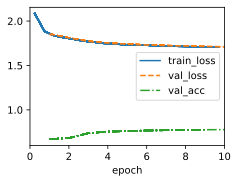

In [45]:
data = FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## prediction (and showing misclasified samples)

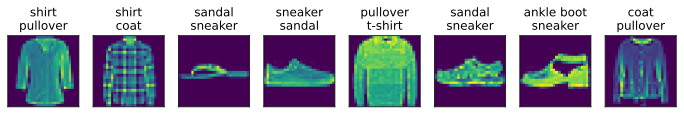

In [49]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(dim=1)

wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]

labels = [a+'\n'+b for a,b in zip(data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

# Concise implementation

In [50]:
import torch
from torch import nn
from torch import functional as F

In [ ]:
class SoftmaxRegression(d2l.Module):
    def __init__(self):
        super().__init__(lr)
        self.save_hyperparameters()
        self.net = nn.Sequential([nn.Flatten(), nn.LazyLinear(nun_outputs)])

    def forward(self, X):
        return self.net(X)